<a href="https://colab.research.google.com/github/KirtiNayak11/SkinCancerDetection_EnsembleLearning/blob/main/SkinCancerDetection_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:02<00:00, 149MB/s]
100% 325M/325M [00:02<00:00, 141MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-malignant-vs-benign.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/skinCancerDetection')
zip_ref.close()

In [ ]:
import tensorflow as tf

In [ ]:
data_dir = '/content/drive/MyDrive/skinCancerDetection/train'

In [ ]:
import os
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

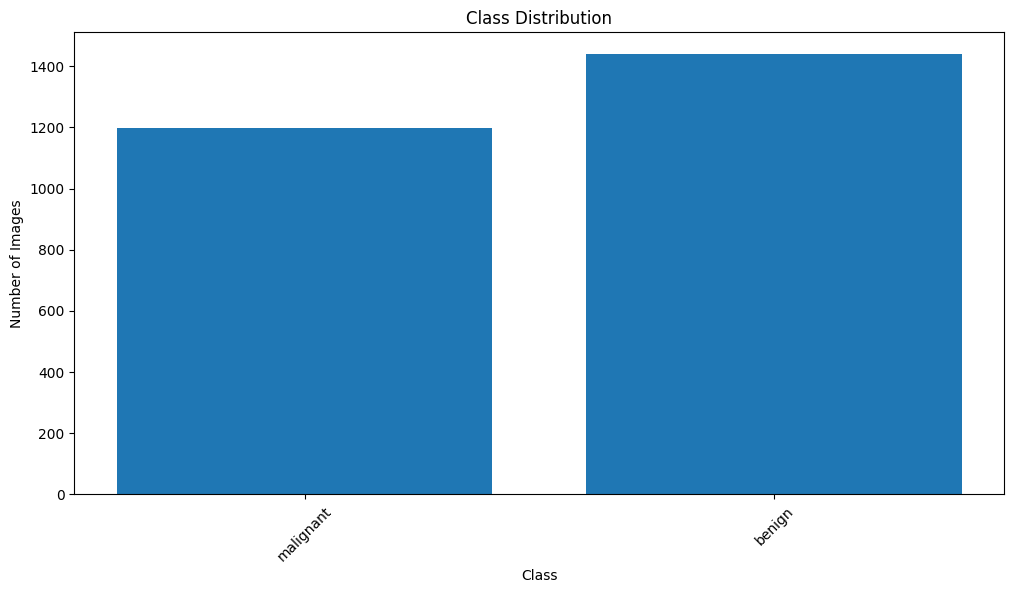

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create the dataset from the specified subdirectories
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/skinCancerDetection/train',
    #labels='inferred',  # Automatically infer labels from subdirectory structure
   # class_names=Task1,  # Specify the included subdirectories
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=True,
    label_mode="categorical"
)

Found 2637 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

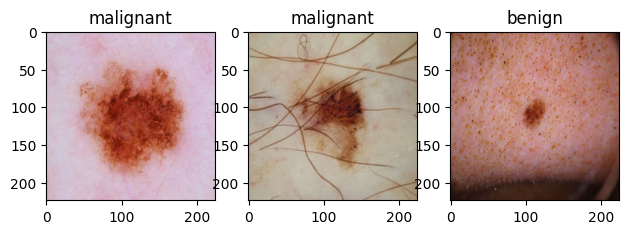

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label_index = tf.where(labels_batch[i] == 1).numpy()[0][0]  # Find the index where label is 1
        plt.title(class_names[label_index])
        #plt.axis("off")

plt.show()

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.2, shuffle=False, shuffle_size=500):
    assert (train_split + val_split ) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)

    return train_ds,val_ds

In [ ]:
train_ds,val_ds = get_dataset_partitions_tf(dataset)

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0)

In [ ]:
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
#from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#from keras.applications.resnet50 import ResNet50
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121

In [ ]:
# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add your custom classification head
model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(2, activation='softmax'))  # Binary classification (0 or 1)


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 7168962 (27.35 MB)
Trainable params: 131458 (513.51 KB)
Non-trainable params: 7037504 (26.85 MB)
___________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam  # Import the optimizer

# Define your learning rate
learning_rate = 0.001  # Adjust this value as needed

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using data generators
history3 = model3.fit(
    train_ds,  # Use the training data generator
    epochs=50,
    batch_size=32,
    validation_data=val_ds,  # Use the validation data generator
    callbacks=[early_stopping]
)


Epoch 1/50
66/66 [==============================] - 512s 8s/step - loss: 0.5108 - accuracy: 0.7547 - val_loss: 0.3641 - val_accuracy: 0.8381
Epoch 2/50
66/66 [==============================] - 480s 7s/step - loss: 0.3914 - accuracy: 0.8314 - val_loss: 0.3136 - val_accuracy: 0.8648
Epoch 3/50
66/66 [==============================] - 484s 7s/step - loss: 0.3585 - accuracy: 0.8414 - val_loss: 0.3024 - val_accuracy: 0.8629
Epoch 4/50
66/66 [==============================] - 495s 8s/step - loss: 0.3273 - accuracy: 0.8580 - val_loss: 0.3268 - val_accuracy: 0.8419
Epoch 5/50
66/66 [==============================] - 436s 7s/step - loss: 0.3150 - accuracy: 0.8532 - val_loss: 0.2914 - val_accuracy: 0.8724
Epoch 6/50
66/66 [==============================] - 492s 7s/step - loss: 0.2931 - accuracy: 0.8703 - val_loss: 0.2965 - val_accuracy: 0.8629
Epoch 7/50
66/66 [==============================] - 426s 6s/step - loss: 0.2832 - accuracy: 0.8807 - val_loss: 0.2704 - val_accuracy: 0.8857
Epoch 8/50
66

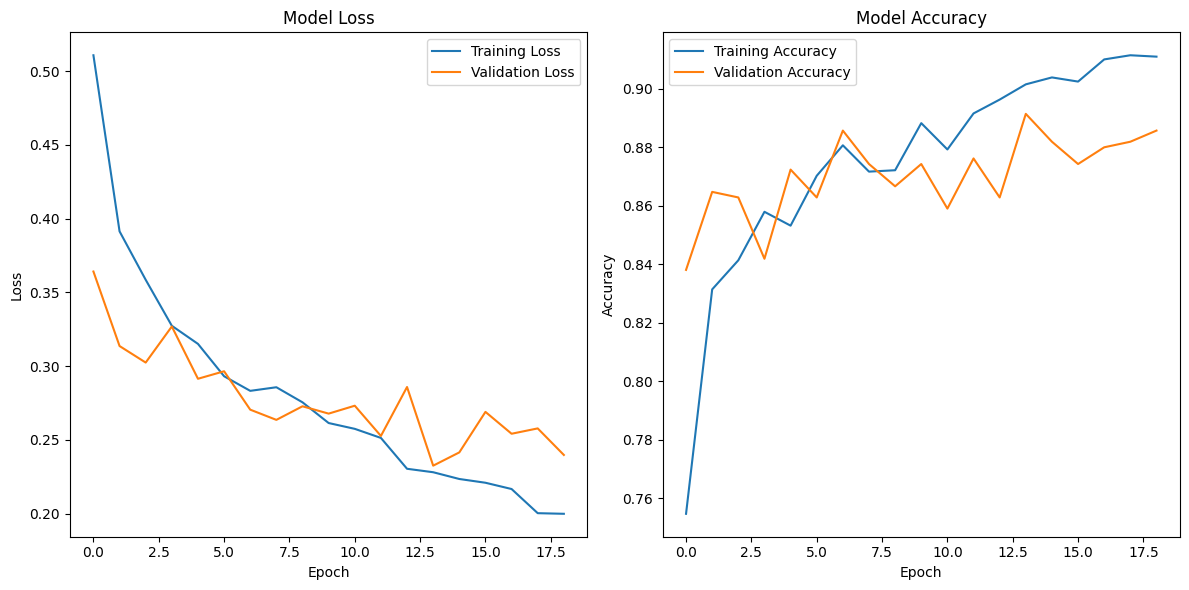

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()




# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Create the dataset from the specified subdirectories
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/skinCancerDetection/test',
    #labels='inferred',  # Automatically infer labels from subdirectory structure
   # class_names=Task1,  # Specify the included subdirectories
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=True,
    label_mode="categorical"
)

Found 660 files belonging to 2 classes.


In [ ]:
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
# Evaluate the model on the test dataset
test_results = model3.evaluate(test_ds)

# Print the test results (e.g., loss and accuracy)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

21/21 [==============================] - 153s 7s/step - loss: 0.2900 - accuracy: 0.8682
Test Loss: 0.2900390326976776
Test Accuracy: 0.8681818246841431


In [ ]:
import numpy as np

1/1 [==============================] - 3s 3s/step
actual label: benign
predicted label: benign


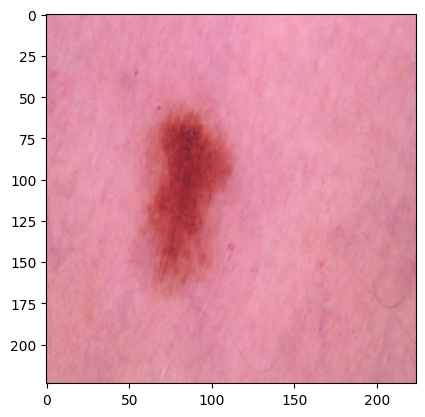

In [ ]:
for images, labels in test_ds.take(1):
        for i in range(1):
            image = images[i]
            actual_label = tf.argmax(labels[i]).numpy()

            plt.imshow(image)

            predictedValue = model3.predict(np.expand_dims(image, axis=0))
            predicted_label = np.argmax(predictedValue)

            print("actual label:", class_names[actual_label])
            print("predicted label:", class_names[predicted_label])


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming you have true labels for the test dataset in a separate list
true_labels = []  # Replace this with your true labels

# Collect the predicted labels using model.predict
predicted_labels = []

for image_batch, labels_batch in test_ds:
    n= image_batch.shape[0]

    for i in range(n):
      batch_prediction = model3.predict(np.expand_dims(image_batch[i], axis=0))
      predicted_indices_batch = np.argmax(batch_prediction)
      predicted_labels.append(predicted_indices_batch)

      label_index = tf.where(labels_batch[i] == 1).numpy()[0][0]
      true_labels.append(label_index)

1/1 [==============================] - 0s 180ms/step


In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[320  40]
 [ 47 253]]


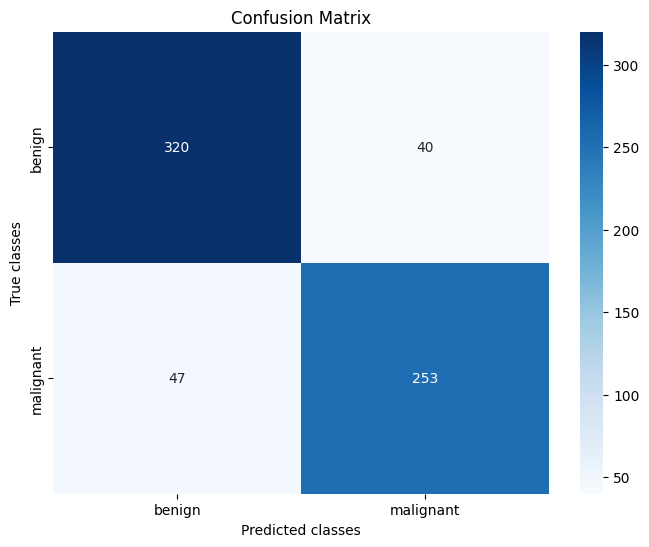

In [ ]:
import seaborn as sns
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true is the true labels and y_pred is the predicted labels for a multiclass problem
accuracy = accuracy_score(true_labels, predicted_labels)

# Specify the 'average' parameter for precision, recall, and f1_score
precision = precision_score(true_labels, predicted_labels, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
recall = recall_score(true_labels, predicted_labels, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8681818181818182
Precision: 0.8680921611611366
Recall: 0.8681818181818182
F1-Score: 0.8680384149114939
Confusion Matrix:
[[320  40]
 [ 47 253]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
# Save the entire model including architecture, optimizer, and learned weights
model3.save("/content/drive/MyDrive/F1/Densenet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
